<h3 align = 'center', style='color:red'> Import Necessary libraries </h3>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, make_scorer,f1_score, roc_curve , auc
import optuna
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from joblib import dump
import mlflow

In [2]:
df_customers = pd.read_csv('datasets/customers.csv')
df_loans = pd.read_csv('datasets/loans.csv')
df_bureau_data = pd.read_csv('datasets/bureau_data.csv')

In [3]:
df_customers.head(2)

,cust_id,age,gender,marital_status,employment_status,income,number_of_dependants,residence_type,years_at_current_address,city,state,zipcode
0,C00001,44,M,Married,Self-Employed,2586000,3,Owned,27,Delhi,Delhi,110001
1,C00002,38,M,Married,Salaried,1206000,3,Owned,4,Chennai,Tamil Nadu,600001


In [4]:
df_loans.head(2)

,loan_id,cust_id,loan_purpose,loan_type,sanction_amount,loan_amount,processing_fee,gst,net_disbursement,loan_tenure_months,principal_outstanding,bank_balance_at_application,disbursal_date,installment_start_dt,default
0,L00001,C00001,Auto,Secured,3004000,2467000,49340.0,444060,1973600,33,1630408,873386,2019-07-24,2019-08-10,False
1,L00002,C00002,Home,Secured,4161000,3883000,77660.0,698940,3106400,30,709309,464100,2019-07-24,2019-08-15,False


In [5]:
#Merging two dfs.
df = pd.merge(df_customers,df_loans, on= 'cust_id')

In [6]:
df_bureau_data.head(2)

,cust_id,number_of_open_accounts,number_of_closed_accounts,total_loan_months,delinquent_months,total_dpd,enquiry_count,credit_utilization_ratio
0,C00001,1,1,42,0,0,3,7
1,C00002,3,1,96,12,60,5,4


In [7]:
df = pd.merge(df,df_bureau_data,on='cust_id')

In [8]:
df.head(2)

,cust_id,age,gender,marital_status,employment_status,income,number_of_dependants,residence_type,years_at_current_address,city,...,disbursal_date,installment_start_dt,default,number_of_open_accounts,number_of_closed_accounts,total_loan_months,delinquent_months,total_dpd,enquiry_count,credit_utilization_ratio
0,C00001,44,M,Married,Self-Employed,2586000,3,Owned,27,Delhi,...,2019-07-24,2019-08-10,False,1,1,42,0,0,3,7
1,C00002,38,M,Married,Salaried,1206000,3,Owned,4,Chennai,...,2019-07-24,2019-08-15,False,3,1,96,12,60,5,4


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   cust_id                      50000 non-null  object 
 1   age                          50000 non-null  int64  
 2   gender                       50000 non-null  object 
 3   marital_status               50000 non-null  object 
 4   employment_status            50000 non-null  object 
 5   income                       50000 non-null  int64  
 6   number_of_dependants         50000 non-null  int64  
 7   residence_type               49938 non-null  object 
 8   years_at_current_address     50000 non-null  int64  
 9   city                         50000 non-null  object 
 10  state                        50000 non-null  object 
 11  zipcode                      50000 non-null  int64  
 12  loan_id                      50000 non-null  object 
 13  loan_purpose    

In [10]:
df.default.unique()

array([False,  True])

In [11]:
df.default = df.default.astype(int)
df.default.value_counts()

default
0    45703
1     4297
Name: count, dtype: int64

### Spliting dataset into train and test

In [12]:
X = df.drop('default',axis = 1)
y = df.default
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25,random_state = 42)

In [13]:
X_train.shape, y_train.shape

((37500, 32), (37500,))

In [14]:
df_train = pd.concat([X_train,y_train],axis = 1)
df_test = pd.concat([X_test,y_test],axis = 1)

In [15]:
df_train.shape, df_test.shape

((37500, 33), (12500, 33))

<h3 align = 'center', style='color:red'> Data Cleaning </h3>

#### Handling missing values and duplicates

In [16]:
df_train.isna().sum()

cust_id                         0
age                             0
gender                          0
marital_status                  0
employment_status               0
income                          0
number_of_dependants            0
residence_type                 48
years_at_current_address        0
city                            0
state                           0
zipcode                         0
loan_id                         0
loan_purpose                    0
loan_type                       0
sanction_amount                 0
loan_amount                     0
processing_fee                  0
gst                             0
net_disbursement                0
loan_tenure_months              0
principal_outstanding           0
bank_balance_at_application     0
disbursal_date                  0
installment_start_dt            0
number_of_open_accounts         0
number_of_closed_accounts       0
total_loan_months               0
delinquent_months               0
total_dpd     

In [17]:
df_train.residence_type.unique()

array(['Owned', 'Mortgage', 'Rented', nan], dtype=object)

In [18]:
residence_mode = df_train.residence_type.mode()[0]
df_train.residence_type.fillna(residence_mode,inplace = True)
df_train.residence_type.unique()

C:\Users\Moksh Jain\AppData\Local\Temp\ipykernel_18792\565617050.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train.residence_type.fillna(residence_mode,inplace = True)


array(['Owned', 'Mortgage', 'Rented'], dtype=object)

In [19]:
df_test.residence_type.fillna(residence_mode,inplace = True)
df_test.residence_type.unique()

C:\Users\Moksh Jain\AppData\Local\Temp\ipykernel_18792\4065308180.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_test.residence_type.fillna(residence_mode,inplace = True)


array(['Owned', 'Rented', 'Mortgage'], dtype=object)

In [20]:
df_train.duplicated().sum()

np.int64(0)

#### Handling Outliers

In [21]:
continous_col = df.select_dtypes(['int64','float64']).columns
categorial_col = df.select_dtypes(['object']).columns

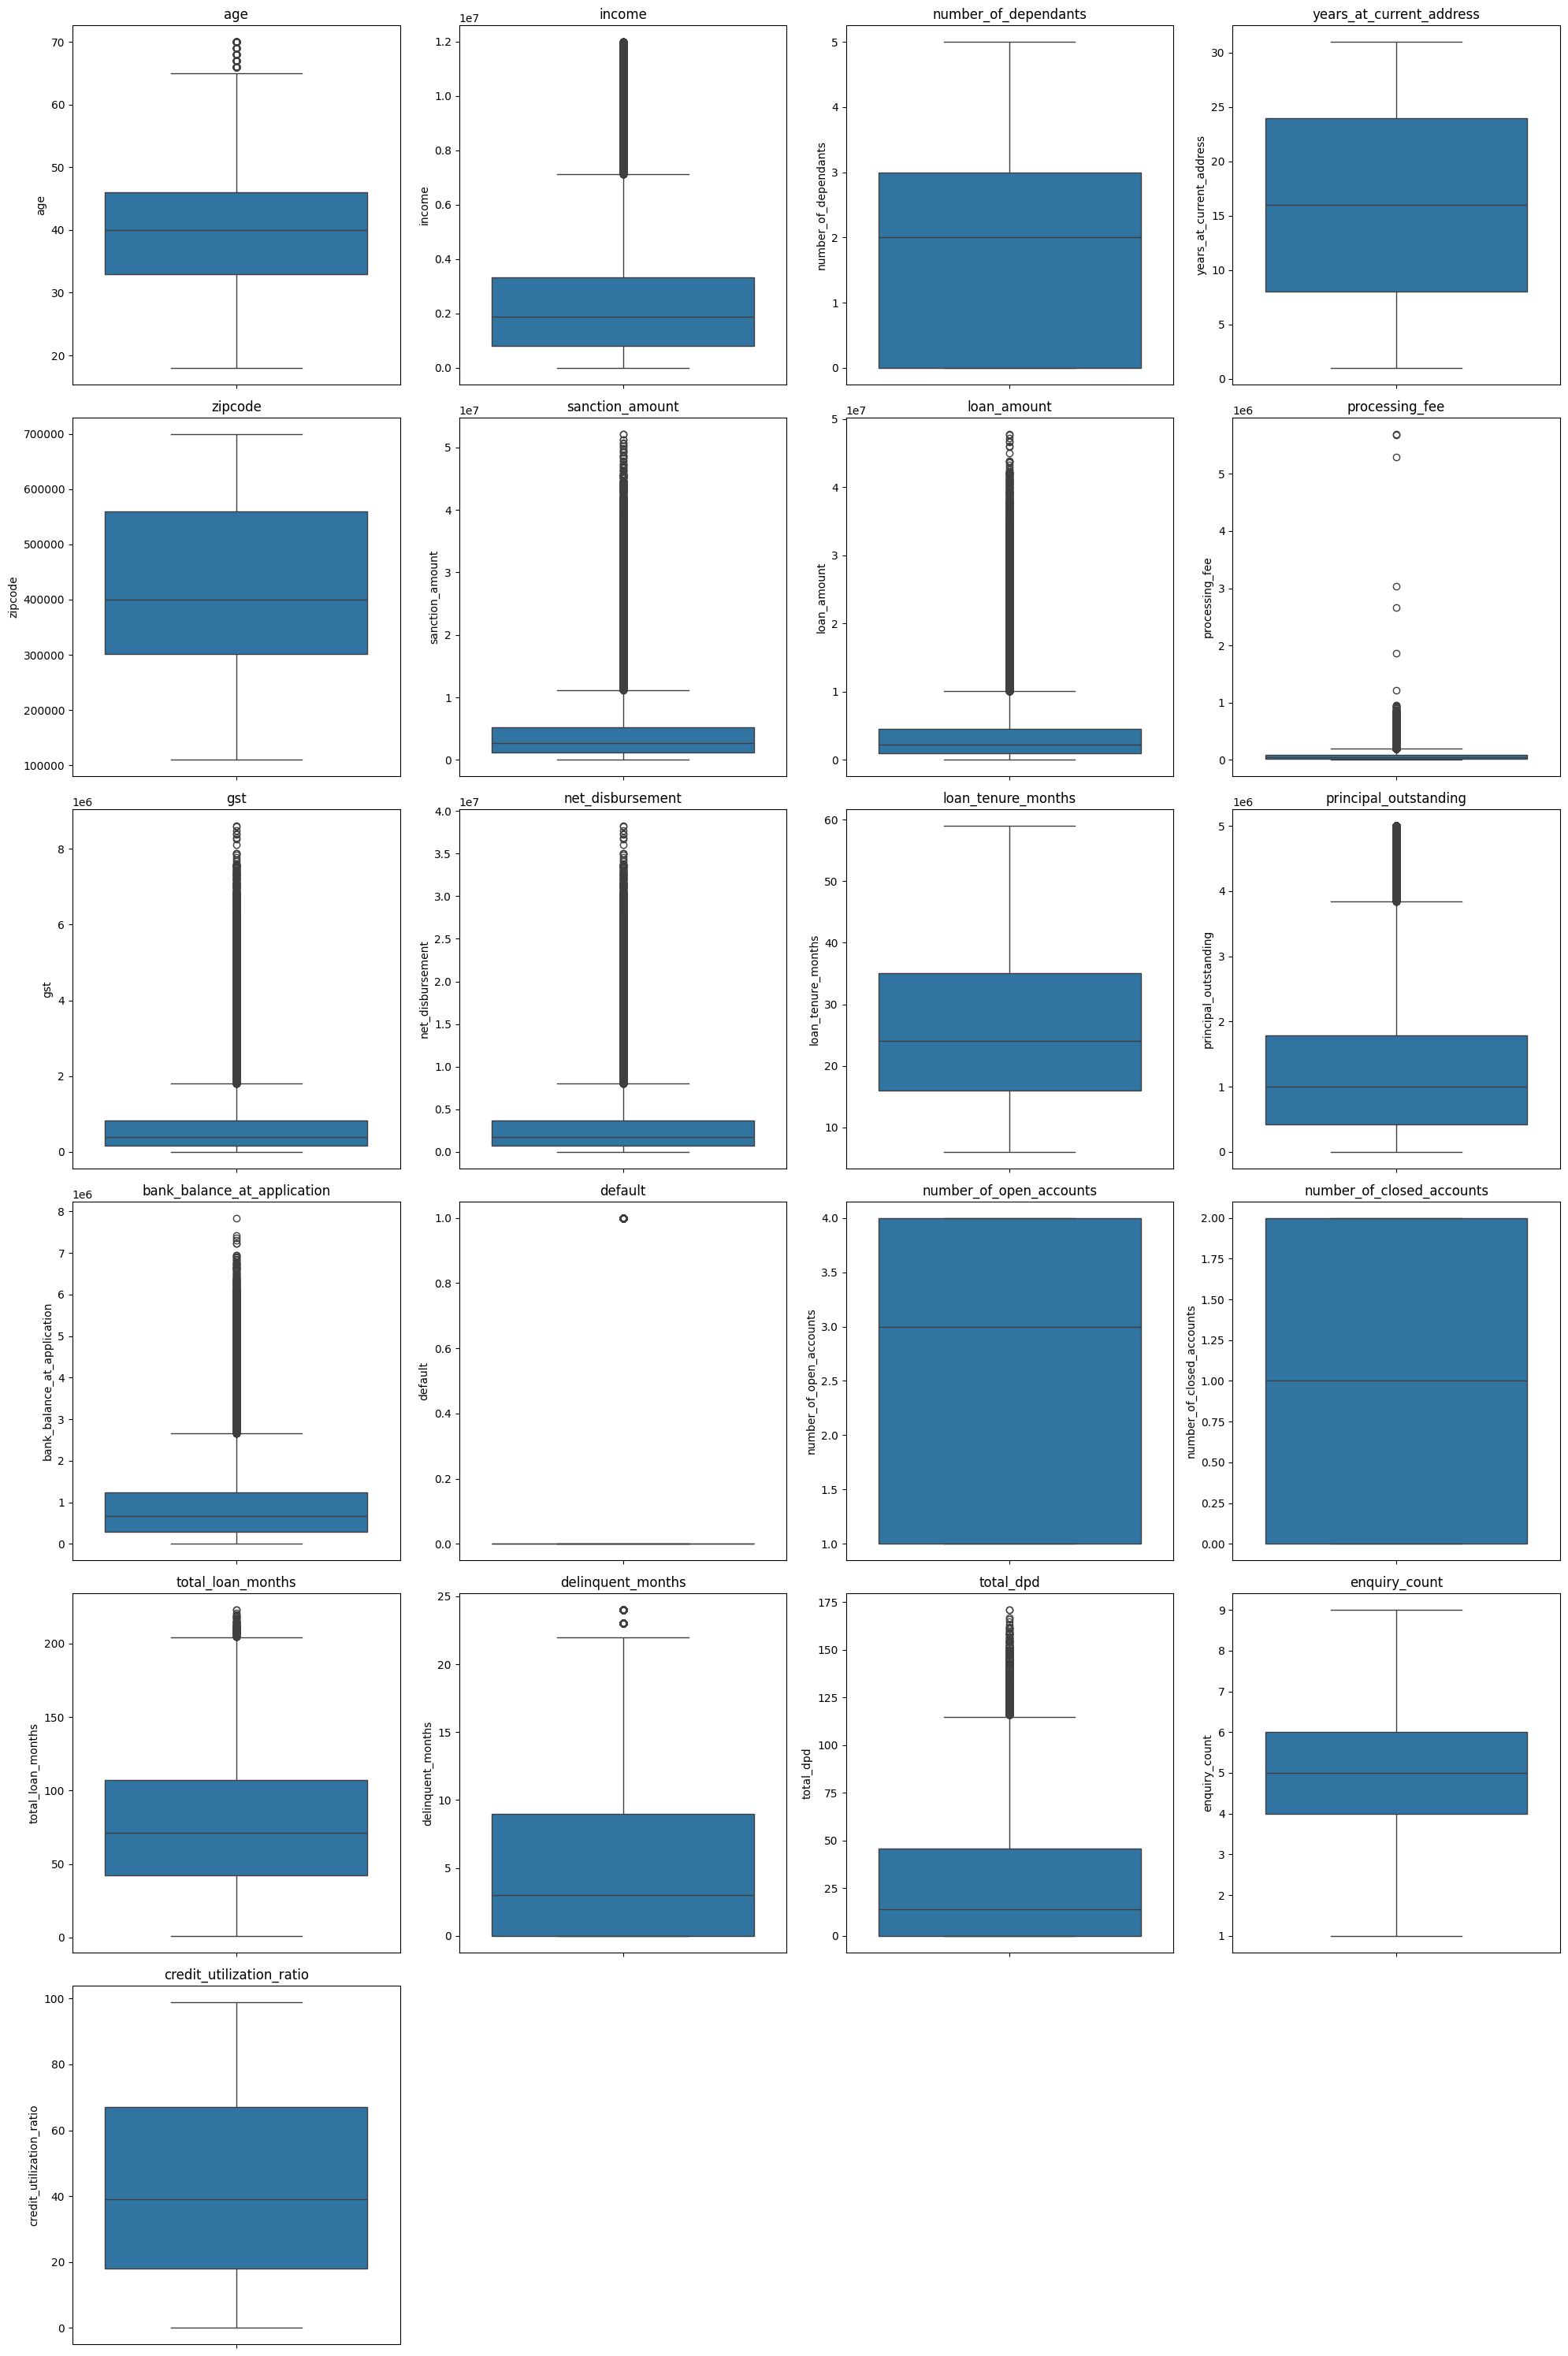

In [22]:
num_plots = len(continous_col)
num_col = 4
num_row = int(np.ceil(num_plots/num_col))

fig,axs = plt.subplots(num_row,num_col,figsize =(5*num_col,5*num_row))
axs = axs.flatten()
for i,col in enumerate(continous_col):
    sns.boxplot(df[col],ax = axs[i])
    axs[i].set_title(col)
for j in range(i+1, num_row*num_col):
    axs[j].axis('off')
plt.tight_layout()
plt.show()

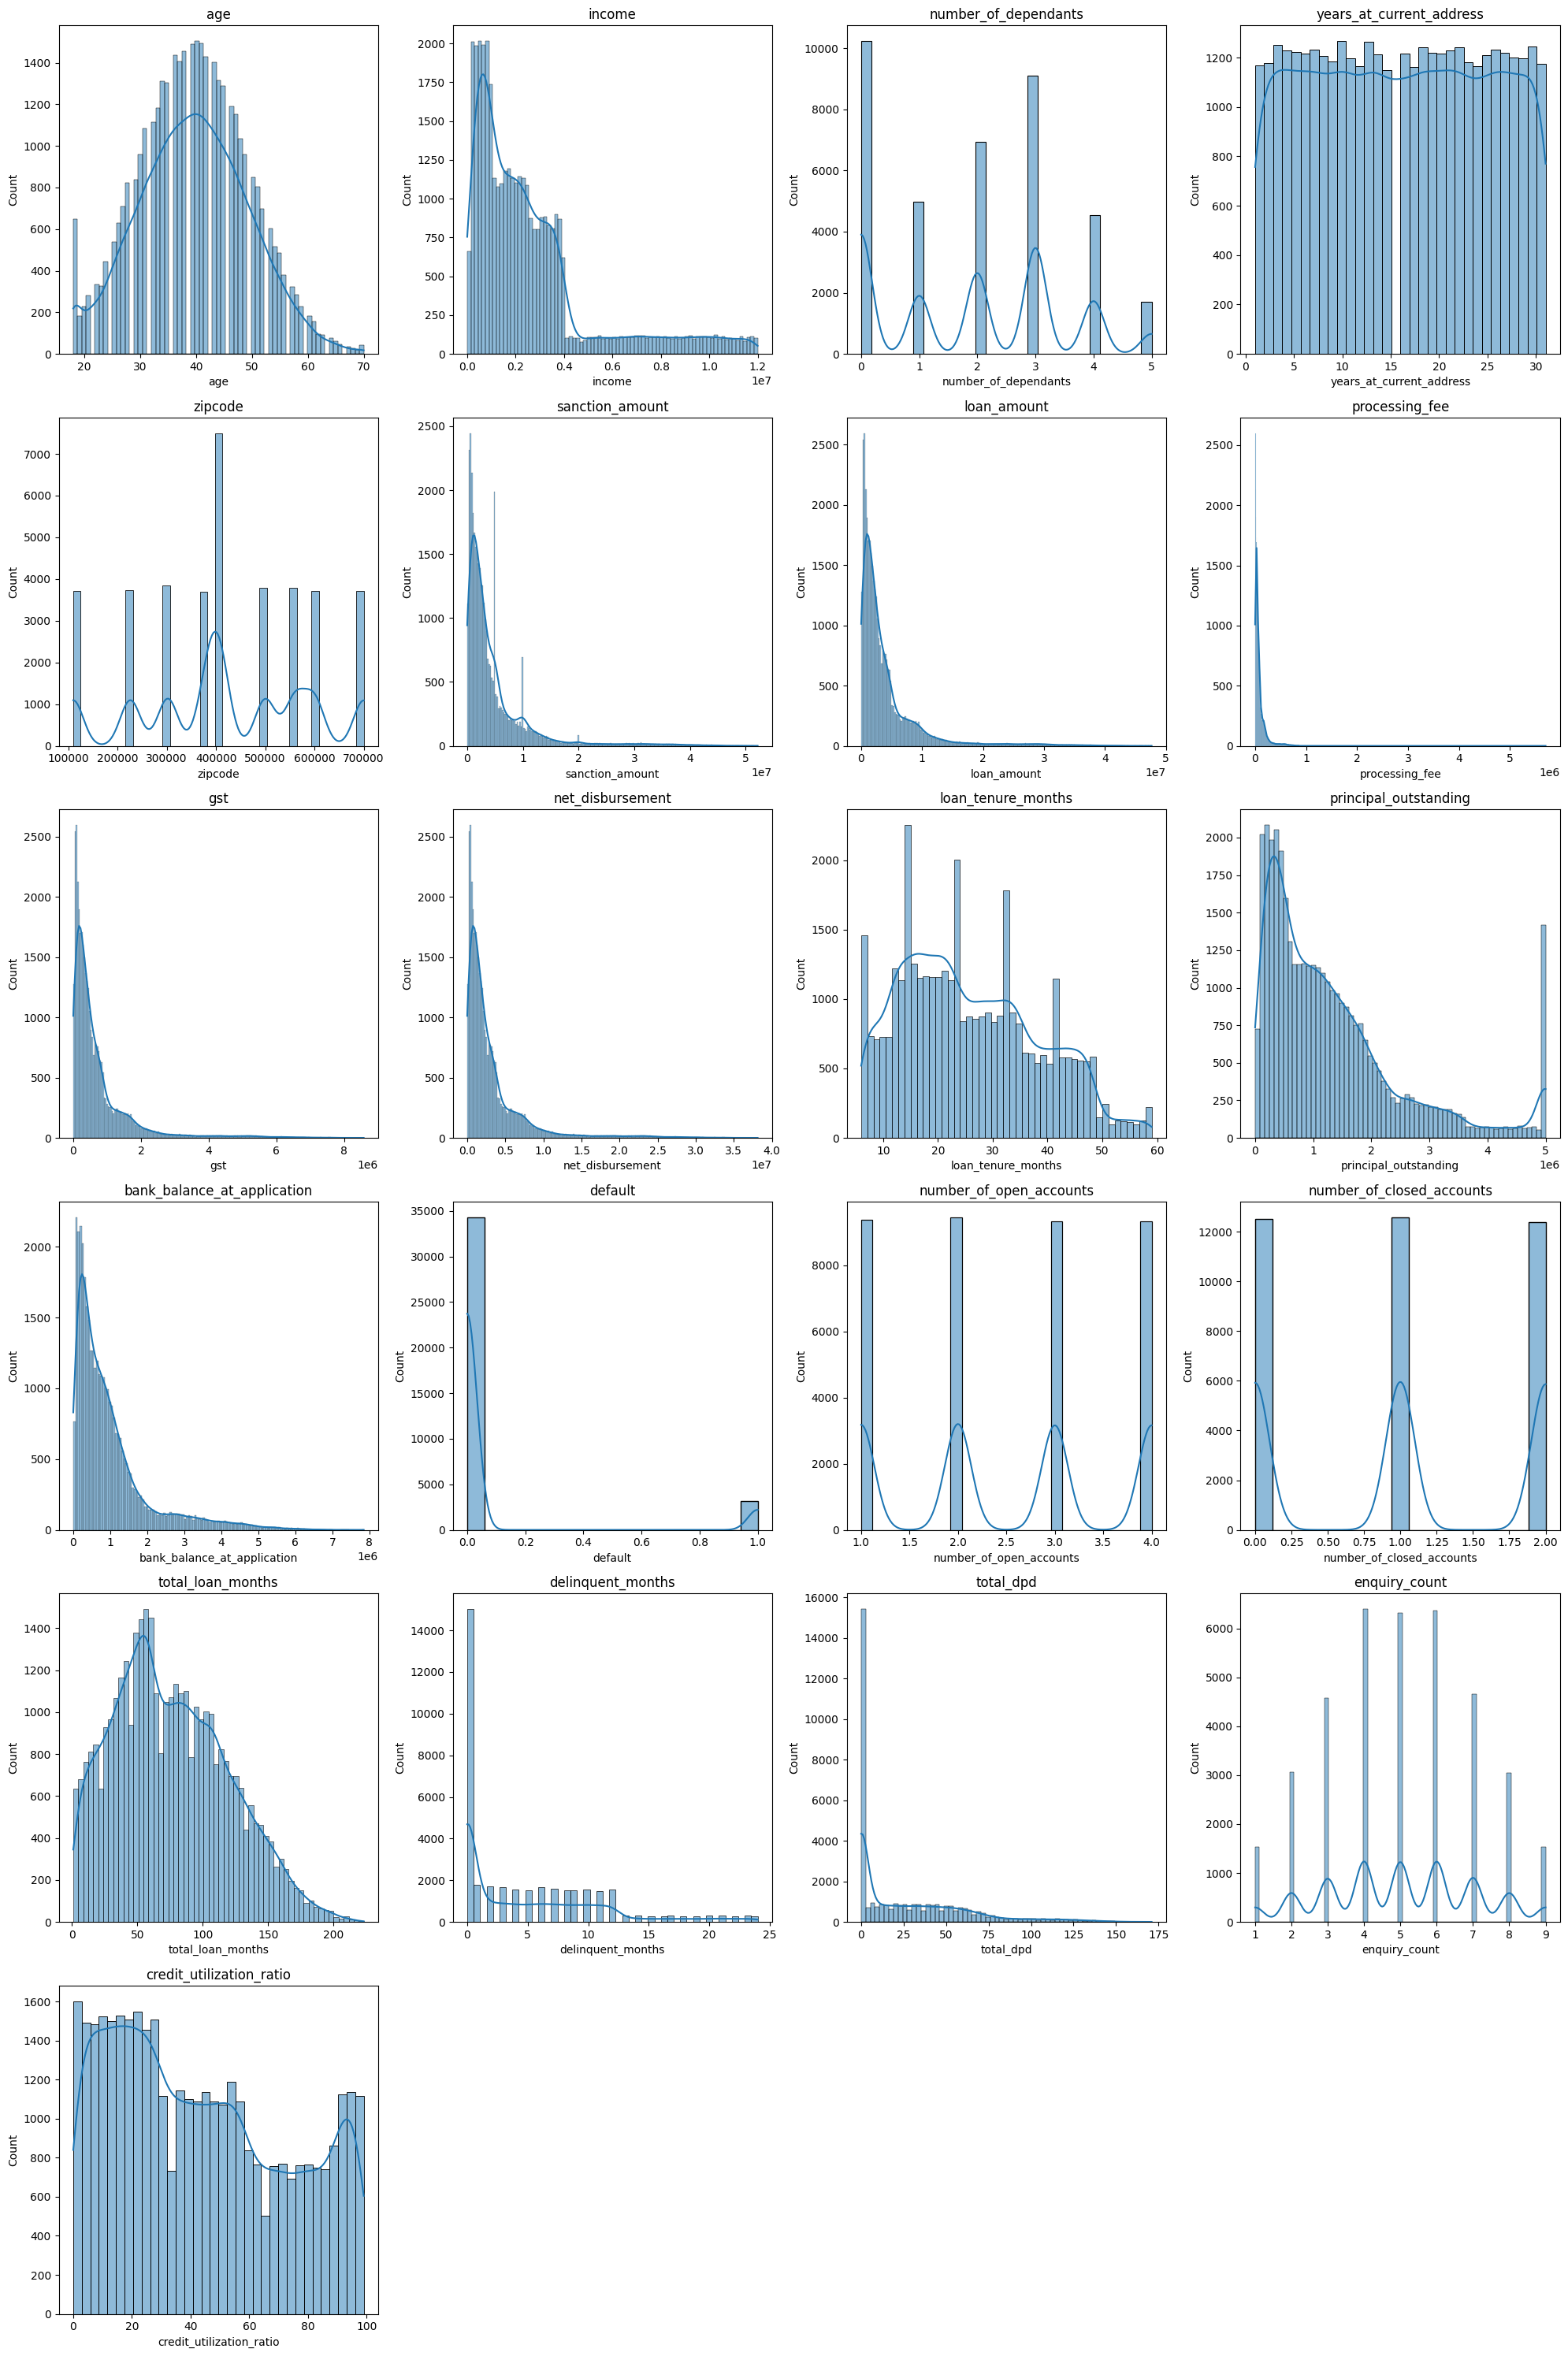

In [23]:
num_plots = len(continous_col)
num_col = 4
num_row = int(np.ceil(num_plots/num_col))

fig,axs = plt.subplots(num_row,num_col,figsize =(5*num_col,5*num_row))
axs = axs.flatten()
for i,col in enumerate(continous_col):
    sns.histplot(df_train[col],ax = axs[i],kde = True)
    axs[i].set_title(col)
for j in range(i+1, num_row*num_col):
    axs[j].axis('off')
plt.tight_layout()
plt.show()

In [22]:
df_train.processing_fee.describe()

count    3.750000e+04
mean     8.072411e+04
std      1.208307e+05
min      0.000000e+00
25%      1.918000e+04
50%      4.470000e+04
75%      9.200000e+04
max      5.698030e+06
Name: processing_fee, dtype: float64

In [23]:
df_train[(df_train.processing_fee/df_train.loan_amount)>=0.03][['loan_amount','processing_fee']]

,loan_amount,processing_fee
23981,2234000,2.669791e+06
9898,3626000,5.293544e+06
47089,1738000,1.858965e+06
33705,3812000,5.678021e+06
12294,4639000,5.698030e+06
28174,966000,1.214493e+06
29305,2616000,3.036378e+06


In [24]:
df_train_1 =df_train[(df_train.processing_fee/df_train.loan_amount)<=0.03].copy()
df_test_1 =df_test[(df_test.processing_fee/df_test.loan_amount)<=0.03].copy()

In [25]:
df_train_1[(df_train_1.processing_fee/df_train_1.loan_amount)>=0.03]

,cust_id,age,gender,marital_status,employment_status,income,number_of_dependants,residence_type,years_at_current_address,city,...,disbursal_date,installment_start_dt,number_of_open_accounts,number_of_closed_accounts,total_loan_months,delinquent_months,total_dpd,enquiry_count,credit_utilization_ratio,default


In [26]:
for col in categorial_col:
    print(col ,'-->', df_train_1[col].unique())

cust_id --> ['C27435' 'C13401' 'C00884' ... 'C38159' 'C00861' 'C15796']
gender --> ['F' 'M']
marital_status --> ['Single' 'Married']
employment_status --> ['Salaried' 'Self-Employed']
residence_type --> ['Owned' 'Mortgage' 'Rented']
city --> ['Ahmedabad' 'Delhi' 'Lucknow' 'Bangalore' 'Jaipur' 'Hyderabad' 'Kolkata'
 'Pune' 'Chennai' 'Mumbai']
state --> ['Gujarat' 'Delhi' 'Uttar Pradesh' 'Karnataka' 'Rajasthan' 'Telangana'
 'West Bengal' 'Maharashtra' 'Tamil Nadu']
loan_id --> ['L27435' 'L13401' 'L00884' ... 'L38159' 'L00861' 'L15796']
loan_purpose --> ['Home' 'Auto' 'Personal' 'Education' 'Personaal']
loan_type --> ['Secured' 'Unsecured']
disbursal_date --> ['2022-04-21' '2020-11-24' '2019-08-25' ... '2024-04-06' '2021-11-30'
 '2021-11-24']
installment_start_dt --> ['2022-05-21' '2020-12-11' '2019-09-19' ... '2024-08-16' '2019-07-27'
 '2022-12-02']


In [27]:
df_train_1.loan_purpose = df_train_1.loan_purpose.replace('Personaal','Personal')
df_test_1.loan_purpose =df_test_1.loan_purpose.replace('Personaal','Personal')
df_train_1.loan_purpose.unique()

array(['Home', 'Auto', 'Personal', 'Education'], dtype=object)

<h3 align = 'center', style='color:red'> Exploratory Data Analysis </h3>

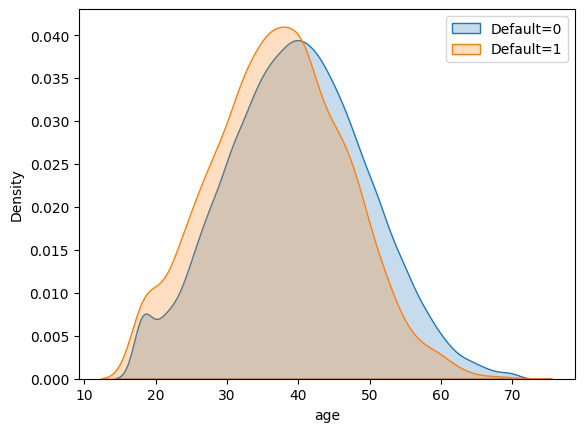

In [30]:
sns.kdeplot(df_train[df_train.default == 0]['age'],label = "Default=0",fill = True)
sns.kdeplot(df_train[df_train.default == 1]['age'],label = 'Default=1',fill = True)
plt.legend()

In [31]:
continous_col

Index(['age', 'income', 'number_of_dependants', 'years_at_current_address',
       'zipcode', 'sanction_amount', 'loan_amount', 'processing_fee', 'gst',
       'net_disbursement', 'loan_tenure_months', 'principal_outstanding',
       'bank_balance_at_application', 'default', 'number_of_open_accounts',
       'number_of_closed_accounts', 'total_loan_months', 'delinquent_months',
       'total_dpd', 'enquiry_count', 'credit_utilization_ratio'],
      dtype='object')

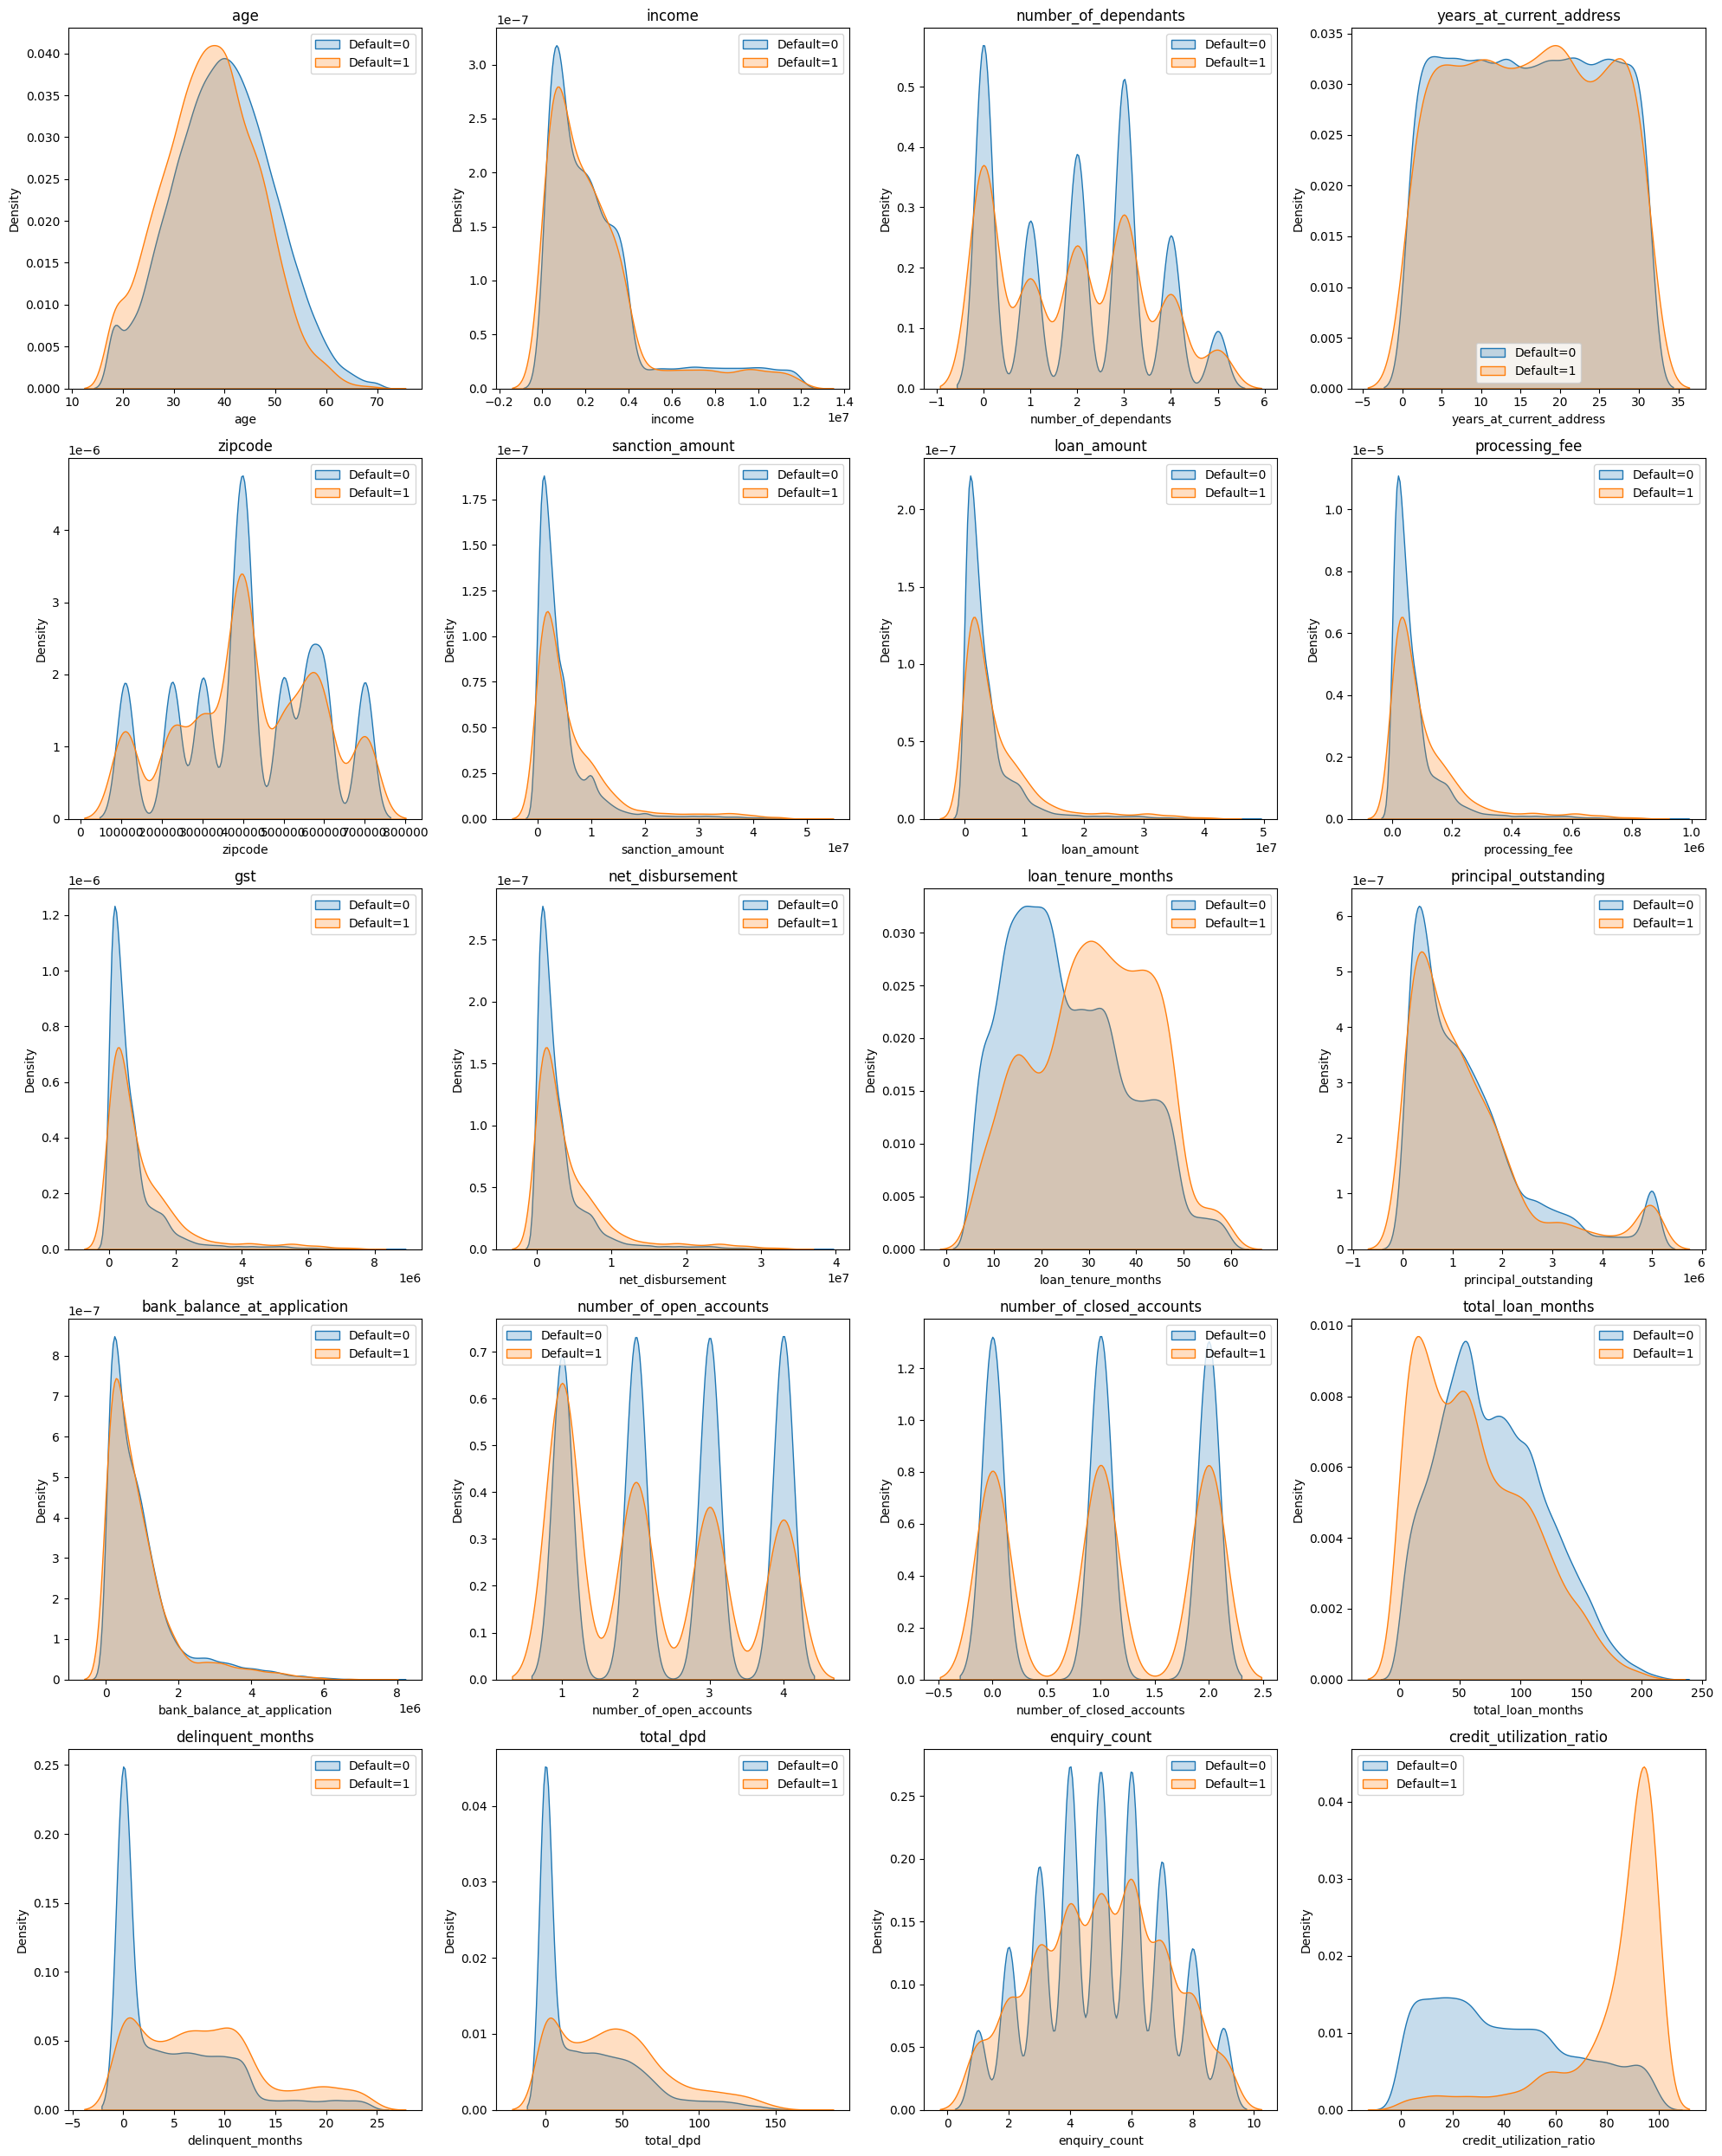

In [32]:
num_plots = len(continous_col)-1
num_col = 4
num_row = int(np.ceil(num_plots/num_col))

fig,axs = plt.subplots(num_row,num_col,figsize =(5*num_col,5*num_row))
axs = axs.flatten()
for i,col in enumerate(continous_col.delete(13)):
    sns.kdeplot(df_train_1[df_train_1.default == 0][col],label = "Default=0",fill = True,ax = axs[i])
    sns.kdeplot(df_train_1[df_train_1.default == 1][col],label = 'Default=1',fill = True,ax = axs[i])
    axs[i].set_title(col)
    axs[i].legend()
plt.tight_layout()
plt.show()

Insights:  
- Younger Age people are likely to be more defaulters.
- In columns delinquent months, total dpd, credit utilization, loan tenure higher values indicate key likelihood of becoming a default. These four looks like a strong predictor.

<h3 align = 'center', style='color:red'>Feautre Engineering</h3>

### Feature Creation

In [28]:
#Loan to income ration
df_train_1['loan_to_income'] = df_train_1['loan_amount']/df_train_1['income']
df_test_1['loan_to_income'] = df_test_1['loan_amount']/df_test_1['income']

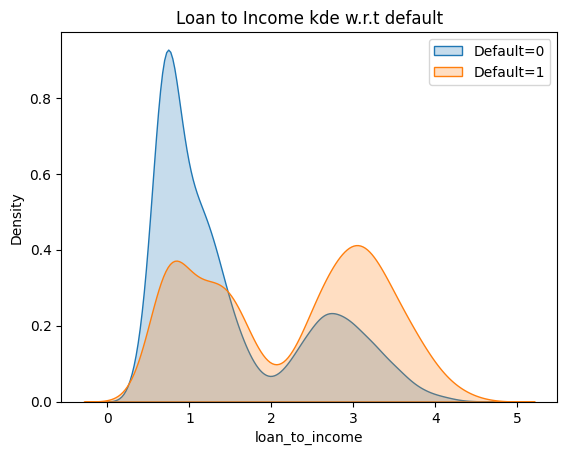

In [29]:
sns.kdeplot(df_train_1[df_train_1.default ==0]['loan_to_income'],label = 'Default=0',fill =True)
sns.kdeplot(df_train_1[df_train_1.default ==1]['loan_to_income'],label = 'Default=1',fill = True)
plt.title('Loan to Income kde w.r.t default')
plt.legend()
plt.show()

In [30]:
#Delinquent month to loan month ratio
df_train_1['delinquency_ratio'] = df_train_1['delinquent_months']*100/df_train_1['total_loan_months']
df_test_1['delinquency_ratio'] = df_test_1['delinquent_months']*100/df_test_1['total_loan_months']

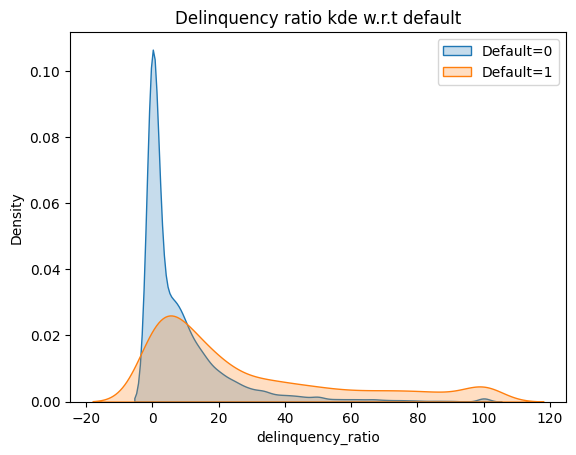

In [31]:
sns.kdeplot(df_train_1[df_train_1.default ==0]['delinquency_ratio'],label = 'Default=0',fill =True)
sns.kdeplot(df_train_1[df_train_1.default ==1]['delinquency_ratio'],label = 'Default=1',fill = True)
plt.title('Delinquency ratio kde w.r.t default')
plt.legend()
plt.show()

In [32]:
#Average dpd per delinquent months
df_train_1['average_dpd_per_delinquency'] = np.where(
    df_train_1['delinquent_months'] !=0,
    df_train_1['total_dpd']/df_train_1['delinquent_months'],
    0
)
df_test_1['average_dpd_per_delinquency'] = np.where(
    df_test_1['delinquent_months'] !=0,
    df_test_1['total_dpd']/df_test_1['delinquent_months'],
    0
)

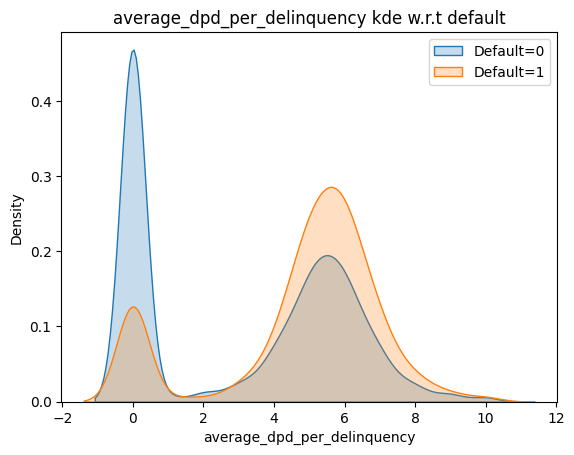

In [33]:
sns.kdeplot(df_train_1[df_train_1.default ==0]['average_dpd_per_delinquency'],label = 'Default=0',fill =True)
sns.kdeplot(df_train_1[df_train_1.default ==1]['average_dpd_per_delinquency'],label = 'Default=1',fill = True)
plt.title('average_dpd_per_delinquency kde w.r.t default')
plt.legend()
plt.show()

Insights:
- All the three features found to be good predictors and for low values we have less defaulters.

### Feature Selection

In [34]:
df_train_1.columns

Index(['cust_id', 'age', 'gender', 'marital_status', 'employment_status',
       'income', 'number_of_dependants', 'residence_type',
       'years_at_current_address', 'city', 'state', 'zipcode', 'loan_id',
       'loan_purpose', 'loan_type', 'sanction_amount', 'loan_amount',
       'processing_fee', 'gst', 'net_disbursement', 'loan_tenure_months',
       'principal_outstanding', 'bank_balance_at_application',
       'disbursal_date', 'installment_start_dt', 'number_of_open_accounts',
       'number_of_closed_accounts', 'total_loan_months', 'delinquent_months',
       'total_dpd', 'enquiry_count', 'credit_utilization_ratio', 'default',
       'loan_to_income', 'delinquency_ratio', 'average_dpd_per_delinquency'],
      dtype='object')

In [35]:
#Technical Removal of Columns
df_train_2 = df_train_1.drop(['cust_id','loan_id'],axis = 1)
df_test_2 = df_test_1.drop(['cust_id','loan_id'],axis = 1)

In [36]:
#Dropping through business understanding
df_train_3 = df_train_2.drop(['income','loan_amount','disbursal_date','installment_start_dt',
                              'delinquent_months','total_loan_months','total_dpd'],axis =1)
df_test_3 = df_test_2.drop(['income','loan_amount','disbursal_date','installment_start_dt',
                              'delinquent_months','total_loan_months','total_dpd'],axis =1)

In [37]:
df_train_3.columns

Index(['age', 'gender', 'marital_status', 'employment_status',
       'number_of_dependants', 'residence_type', 'years_at_current_address',
       'city', 'state', 'zipcode', 'loan_purpose', 'loan_type',
       'sanction_amount', 'processing_fee', 'gst', 'net_disbursement',
       'loan_tenure_months', 'principal_outstanding',
       'bank_balance_at_application', 'number_of_open_accounts',
       'number_of_closed_accounts', 'enquiry_count',
       'credit_utilization_ratio', 'default', 'loan_to_income',
       'delinquency_ratio', 'average_dpd_per_delinquency'],
      dtype='object')

In [38]:
df_train_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37487 entries, 27434 to 15795
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   age                          37487 non-null  int64  
 1   gender                       37487 non-null  object 
 2   marital_status               37487 non-null  object 
 3   employment_status            37487 non-null  object 
 4   number_of_dependants         37487 non-null  int64  
 5   residence_type               37487 non-null  object 
 6   years_at_current_address     37487 non-null  int64  
 7   city                         37487 non-null  object 
 8   state                        37487 non-null  object 
 9   zipcode                      37487 non-null  int64  
 10  loan_purpose                 37487 non-null  object 
 11  loan_type                    37487 non-null  object 
 12  sanction_amount              37487 non-null  int64  
 13  processing_fee   

In [39]:
col_to_scale = df_train_3.select_dtypes(['int64','float64']).columns.tolist()

In [40]:
scaler = MinMaxScaler()
df_train_3[col_to_scale]= scaler.fit_transform(df_train_3[col_to_scale])
df_test_3[col_to_scale]= scaler.transform(df_test_3[col_to_scale])

In [41]:
df_train_3

,age,gender,marital_status,employment_status,number_of_dependants,residence_type,years_at_current_address,city,state,zipcode,...,principal_outstanding,bank_balance_at_application,number_of_open_accounts,number_of_closed_accounts,enquiry_count,credit_utilization_ratio,default,loan_to_income,delinquency_ratio,average_dpd_per_delinquency
27434,0.519231,F,Single,Salaried,0.0,Owned,0.133333,Ahmedabad,Gujarat,0.457627,...,0.175096,0.069846,1.000000,1.0,0.875,0.595960,0.0,0.609125,0.066667,0.550000
13400,0.211538,M,Single,Salaried,0.0,Owned,0.800000,Delhi,Delhi,0.000000,...,0.195995,0.119061,0.666667,0.5,0.375,0.929293,0.0,0.184564,0.033613,0.425000
883,0.615385,F,Single,Self-Employed,0.0,Mortgage,0.933333,Lucknow,Uttar Pradesh,0.196610,...,0.271233,0.096133,0.333333,0.5,0.375,0.838384,0.0,0.086193,0.168675,0.557143
7303,0.480769,F,Single,Self-Employed,0.2,Owned,0.866667,Bangalore,Karnataka,0.762712,...,0.026998,0.012511,0.000000,0.5,0.500,0.343434,0.0,0.187259,0.000000,0.000000
45124,0.250000,F,Single,Salaried,0.0,Owned,0.866667,Jaipur,Rajasthan,0.325424,...,0.007257,0.006171,0.333333,0.0,0.500,0.191919,0.0,0.362564,0.096774,0.466667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,0.288462,F,Single,Salaried,0.0,Rented,1.000000,Hyderabad,Telangana,0.661017,...,0.475798,0.177415,1.000000,0.5,0.750,0.939394,1.0,0.248651,0.178295,0.547826
44732,0.288462,F,Single,Salaried,0.0,Owned,0.833333,Delhi,Delhi,0.000000,...,0.330572,0.152811,0.666667,0.0,0.250,0.232323,0.0,0.249977,0.000000,0.000000
38158,0.326923,M,Married,Self-Employed,0.6,Rented,0.133333,Kolkata,West Bengal,1.000000,...,0.294445,0.124432,0.000000,1.0,0.125,0.535354,0.0,0.566568,0.000000,0.000000
860,0.461538,F,Married,Salaried,0.8,Owned,0.166667,Mumbai,Maharashtra,0.491525,...,0.257917,0.083391,0.666667,0.5,0.750,0.171717,0.0,0.281386,0.038462,0.480000


In [42]:
def calculate_vif(data):
    df = pd.DataFrame(columns = ['Feature'])
    df['Feature'] = data.columns
    df['VIF'] = [variance_inflation_factor(data.values,col) for col in range(data.shape[1])]
    return df.sort_values(by='VIF',ascending= False)

In [43]:
calculate_vif(df_train_3[col_to_scale].drop('default',axis = 1))

C:\Users\Moksh Jain\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Feature,VIF
6,gst,inf
5,processing_fee,inf
7,net_disbursement,inf
4,sanction_amount,102.154758
9,principal_outstanding,16.279404
10,bank_balance_at_application,9.283898
15,loan_to_income,6.938251
13,enquiry_count,6.396055
8,loan_tenure_months,6.142561
0,age,5.717145


In [44]:
df_train_3.drop(['gst','processing_fee','net_disbursement','sanction_amount','principal_outstanding'],axis = 1,inplace = True)
df_test_3.drop(['gst','processing_fee','net_disbursement','sanction_amount','principal_outstanding'],axis = 1,inplace = True)

### Confusion Matrix 

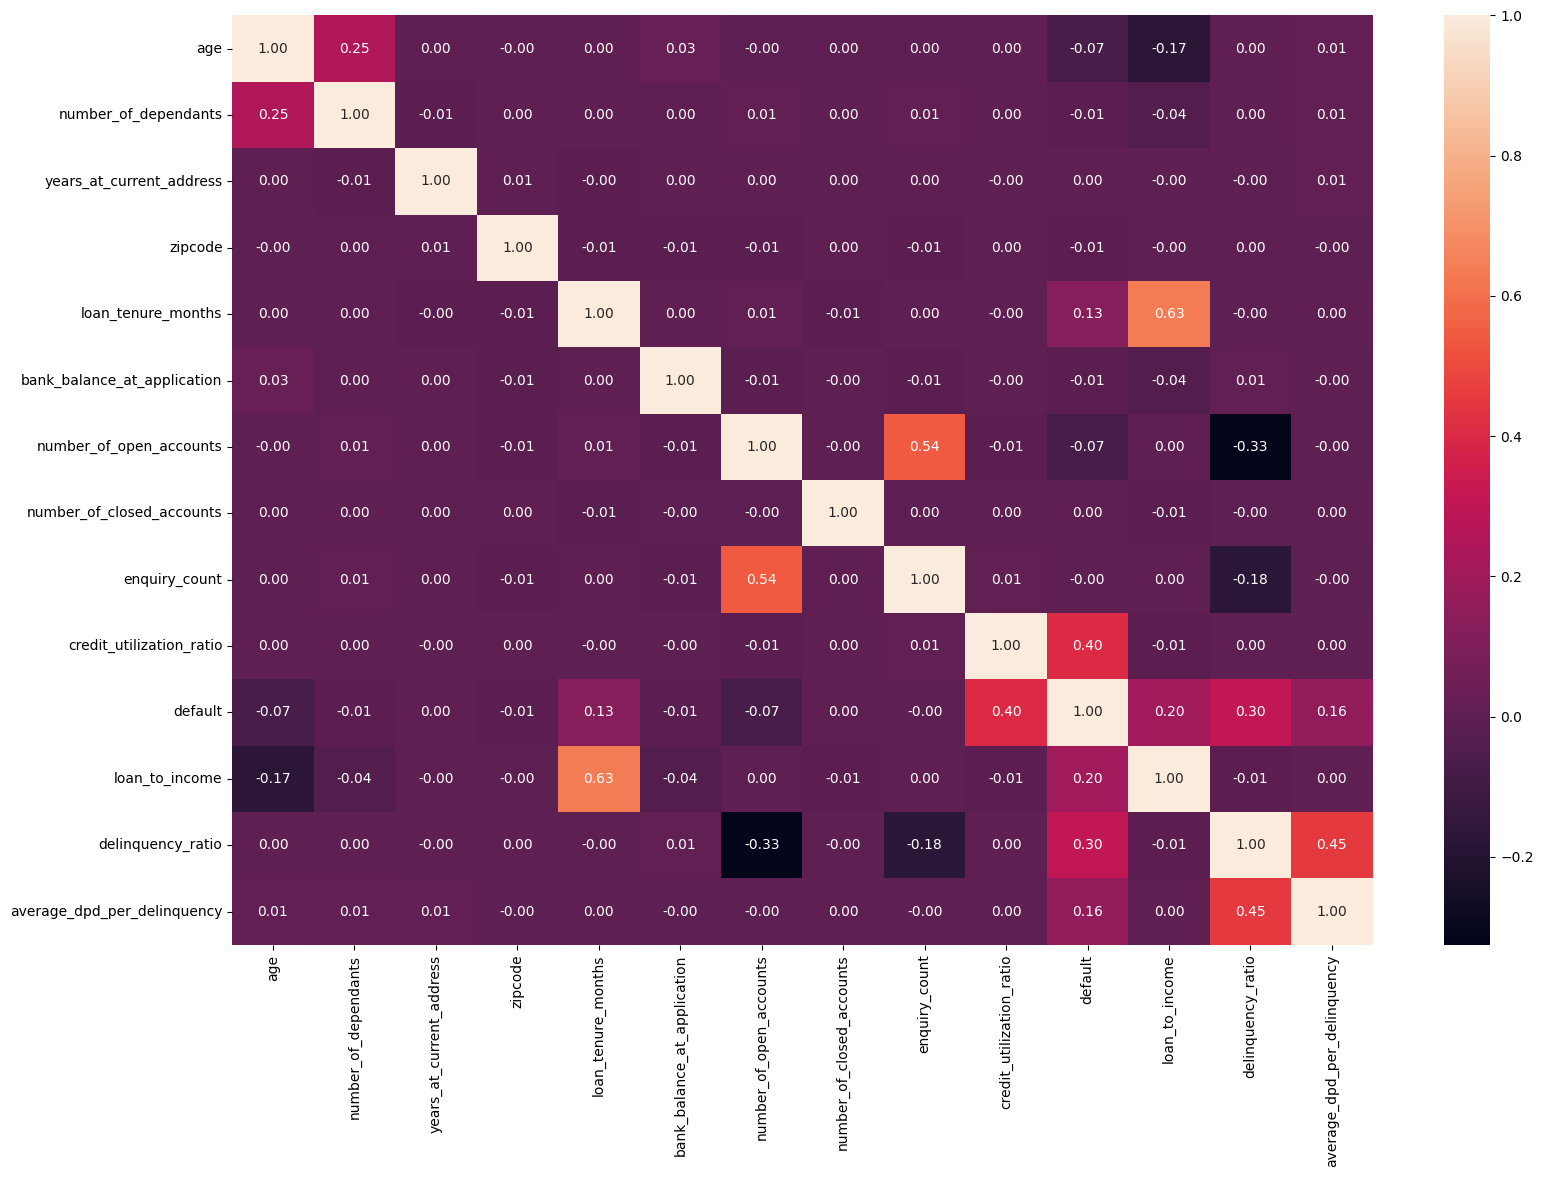

In [45]:
selected_features = df_train_3.select_dtypes(['int64','float64'])
cm = selected_features.corr()
plt.figure(figsize = (15,10))
plt.xticks(rotation= 45)
plt.tight_layout()
sns.heatmap(cm,annot = True,fmt = '.2f')
plt.show()

### Finding IV, WOE

In [46]:
def calculate_woe_iv(df,target):
    feature_ivs = []
    df_iv = pd.DataFrame(columns = ['features','iv'])
    df_iv['features'] = df.columns
    for col,dtype in zip(df.dtypes.index,df.dtypes.values):
        if dtype == 'object':
            grouped = pd.crosstab(df[col],df[target])
        else:
            binned = pd.cut(df[col],bins = 10)
            grouped = pd.crosstab(binned,df[target])
        grouped.columns = ['bad','good']
        total_good = grouped['good'].sum()
        total_bad = grouped['bad'].sum()
        grouped['good_pct'] = grouped['good']/total_good
        grouped['bad_pct'] = grouped['bad']/total_bad
        grouped['woe'] = np.where(grouped['bad_pct'] !=0,np.log(grouped['good_pct']/grouped['bad_pct']),0)
        grouped['iv'] = grouped['woe'] * (grouped['good_pct'] - grouped['bad_pct'])
        total_iv = grouped['iv'].sum()
        feature_ivs.append(total_iv)
    df_iv['iv'] = feature_ivs
    return df_iv.sort_values('iv',ascending = False)


In [47]:
df_iv =calculate_woe_iv(df_train_3,'default')
df_iv

C:\Users\Moksh Jain\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,features,iv
18,default,inf
17,credit_utilization_ratio,2.422823
20,delinquency_ratio,0.678323
19,loan_to_income,0.491740
21,average_dpd_per_delinquency,0.421236
10,loan_purpose,0.393775
5,residence_type,0.259402
12,loan_tenure_months,0.234506
11,loan_type,0.173047
0,age,0.075927


In [48]:
selected_features = df_iv[df_iv['iv']>0.02]['features']

### Feature Encoding

In [49]:
df_train_reduced = df_train_3[selected_features]
df_test_reduced = df_test_3[selected_features]

In [50]:
df_train_reduced = pd.get_dummies(df_train_reduced,drop_first = True)
df_test_reduced = pd.get_dummies(df_test_reduced,drop_first = True)

<h3 align= 'center' style="color:red"> Model Training </h3>

In [51]:
X_train_reduced = df_train_reduced.drop('default',axis = 1)
y_train = df_train_reduced.default
X_test_reduced = df_test_reduced.drop('default',axis = 1)
y_test = df_test_reduced.default

### Attempt 1
- Logistic Regression, Random Forest, XGB
- No handling of class imbalance

In [52]:
lr = LogisticRegression()
lr.fit(X_train_reduced,y_train)
y_pred = lr.predict(X_test_reduced)
report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     11390
         1.0       0.84      0.69      0.76      1108

    accuracy                           0.96     12498
   macro avg       0.90      0.84      0.87     12498
weighted avg       0.96      0.96      0.96     12498



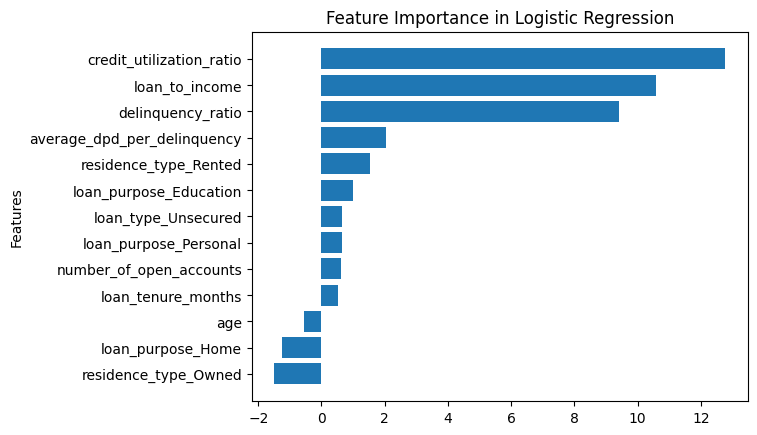

In [53]:
feature_importance = lr.coef_[0]
coef_df = pd.DataFrame(feature_importance,index =X_train_reduced.columns,columns=['Coefficients'])
coef_df=coef_df.sort_values(by='Coefficients',ascending= True)
plt.barh(coef_df.index,coef_df['Coefficients'])
plt.title("Feature Importance in Logistic Regression")
plt.ylabel("Features")
plt.show()

In [54]:
model = RandomForestClassifier()
model.fit(X_train_reduced, y_train)

y_pred = model.predict(X_test_reduced)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     11390
         1.0       0.85      0.70      0.77      1108

    accuracy                           0.96     12498
   macro avg       0.91      0.85      0.87     12498
weighted avg       0.96      0.96      0.96     12498



In [55]:
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_train_reduced, y_train)

y_pred = model.predict(X_test_reduced)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     11390
         1.0       0.82      0.74      0.78      1108

    accuracy                           0.96     12498
   macro avg       0.90      0.86      0.88     12498
weighted avg       0.96      0.96      0.96     12498



### Attempt1: Randomized Search CV on Logistic Regression

In [56]:
param_dist = {
    'C': np.logspace(-4, 4, 20),  # Logarithmically spaced values from 10^-4 to 10^4
    'solver': ['lbfgs', 'saga', 'liblinear', 'newton-cg']   # Algorithm to use in the optimization problem
}

# Create the Logistic Regression model
log_reg = LogisticRegression(max_iter=10000)  # Increased max_iter for convergence

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=log_reg,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings that are sampled
    scoring='f1',
    cv=3,  # 3-fold cross-validation
    verbose=2,
    random_state=42,  # Set a random state for reproducibility
    n_jobs=-1  # Use all available cores
)

# Fit the RandomizedSearchCV to the training data
random_search.fit(X_train_reduced, y_train)

# Print the best parameters and best score
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_reduced)
print("Classification Report:")
print(classification_report(y_test, y_pred))
lr_report_attempt1 = classification_report(y_test,y_pred,output_dict = True)
lr_param_attempt1 = random_search.best_params_
lr_model_attempt1 = best_model

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'solver': 'lbfgs', 'C': np.float64(545.5594781168514)}
Best Score: 0.7629892080748256
Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     11390
         1.0       0.83      0.71      0.77      1108

    accuracy                           0.96     12498
   macro avg       0.90      0.85      0.87     12498
weighted avg       0.96      0.96      0.96     12498



### Attempt1: Randomized Search CV on XGBoost

In [57]:
param_dist = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'scale_pos_weight': [1, 2, 3, 5, 7, 10],
    'reg_alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0],  # L1 regularization term
    'reg_lambda': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0]  # L2 regularization term
}

xgb = XGBClassifier()

random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist, n_iter=100,
                                   scoring='f1', cv=3, verbose=1, n_jobs=-1, random_state=42)

random_search.fit(X_train_reduced, y_train)

# Print the best parameters and best score
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_reduced)
print("Classification Report:")
print(classification_report(y_test, y_pred))
xg_report_attempt1 = classification_report(y_test,y_pred,output_dict = True)
xg_param_attempt1 = random_search.best_params_
xg_model_attempt1 = best_model

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters: {'subsample': 0.8, 'scale_pos_weight': 2, 'reg_lambda': 1.0, 'reg_alpha': 5.0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 0.9}
Best Score: 0.7933632669495553
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     11390
         1.0       0.78      0.82      0.80      1108

    accuracy                           0.96     12498
   macro avg       0.88      0.90      0.89     12498
weighted avg       0.96      0.96      0.96     12498



### Attempt 2


1. Logistic Regression & XGB
1. Handle Class Imbalance Using Under Sampling

In [58]:
under_sampler = RandomUnderSampler()
X_train_res,y_train_res = under_sampler.fit_resample(X_train_reduced,y_train)
y_train_res.value_counts()

default
0.0    3189
1.0    3189
Name: count, dtype: int64

In [59]:
lr = LogisticRegression(**lr_param_attempt1)
lr.fit(X_train_res,y_train_res)
y_pred = lr.predict(X_test_reduced)
report = classification_report(y_test,y_pred)
print(report)
lr_report_attempt2 = classification_report(y_test,y_pred,output_dict = True)
lr_model_attempt2 = lr

              precision    recall  f1-score   support

         0.0       0.99      0.92      0.96     11390
         1.0       0.55      0.95      0.70      1108

    accuracy                           0.93     12498
   macro avg       0.77      0.94      0.83     12498
weighted avg       0.96      0.93      0.93     12498



In [60]:
model = XGBClassifier(**random_search.best_params_)
model.fit(X_train_res, y_train_res)

y_pred = model.predict(X_test_reduced)
report = classification_report(y_test, y_pred)
print(report)
xg_report_attempt2 = classification_report(y_test,y_pred,output_dict = True)
xg_model_attempt2 = model

              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95     11390
         1.0       0.51      0.98      0.67      1108

    accuracy                           0.92     12498
   macro avg       0.76      0.95      0.81     12498
weighted avg       0.96      0.92      0.93     12498



### Attempt 3

1. Logistic Regression
1. Handle Class Imbalance Using SMOTE Tomek
1. Parameter tunning using optuna

In [61]:
smote = SMOTETomek(random_state = 42)
X_train_smt,y_train_smt = smote.fit_resample(X_train_reduced,y_train)
y_train_res.value_counts()

default
0.0    3189
1.0    3189
Name: count, dtype: int64

In [62]:
model = LogisticRegression()
model.fit(X_train_smt, y_train_smt)

y_pred = model.predict(X_test_reduced)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96     11390
         1.0       0.57      0.94      0.71      1108

    accuracy                           0.93     12498
   macro avg       0.78      0.94      0.83     12498
weighted avg       0.96      0.93      0.94     12498



In [63]:
def observation(trial):
    params = {
        'C': trial.suggest_float('C', 1e-4, 1e4, log=True),  # Logarithmically spaced values
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'saga', 'newton-cg']),  # Solvers
        'tol': trial.suggest_float('tol', 1e-6, 1e-1, log=True),  # Logarithmically spaced values for tolerance
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced'])  # Class weights
    }
    
    model = LogisticRegression(**params)
    f1_scorer = make_scorer(f1_score, average='macro')
    scores = cross_val_score(model, X_train_smt, y_train_smt, cv=3, scoring=f1_scorer, n_jobs=-1)
    accuracy = np.mean(scores)
    return accuracy

study = optuna.create_study(direction = "maximize")
study.optimize(observation, n_trials=50)

[I 2025-08-16 15:59:20,710] A new study created in memory with name: no-name-94c7b576-4b55-4cea-ab90-8f9b97abd349
[I 2025-08-16 15:59:21,162] Trial 0 finished with value: 0.9447650964405155 and parameters: {'C': 79.76051287495483, 'solver': 'newton-cg', 'tol': 6.318673762596743e-06, 'class_weight': None}. Best is trial 0 with value: 0.9447650964405155.
[I 2025-08-16 15:59:21,574] Trial 1 finished with value: 0.9447650964405155 and parameters: {'C': 87.17304340164895, 'solver': 'liblinear', 'tol': 0.00018970598684152427, 'class_weight': None}. Best is trial 0 with value: 0.9447650964405155.
[I 2025-08-16 15:59:21,955] Trial 2 finished with value: 0.9448090640768037 and parameters: {'C': 848.5866075736105, 'solver': 'lbfgs', 'tol': 1.0321169502641073e-06, 'class_weight': None}. Best is trial 2 with value: 0.9448090640768037.
[I 2025-08-16 15:59:22,397] Trial 3 finished with value: 0.9447504616182694 and parameters: {'C': 53.66854302658421, 'solver': 'liblinear', 'tol': 0.0008905342548776

In [64]:
print(study.best_trial)

FrozenTrial(number=35, state=TrialState.COMPLETE, values=[0.9449406983572185], datetime_start=datetime.datetime(2025, 8, 16, 15, 59, 32, 503359), datetime_complete=datetime.datetime(2025, 8, 16, 15, 59, 32, 818961), params={'C': 227.82048862951547, 'solver': 'lbfgs', 'tol': 0.00046416595540614726, 'class_weight': 'balanced'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'C': FloatDistribution(high=10000.0, log=True, low=0.0001, step=None), 'solver': CategoricalDistribution(choices=('lbfgs', 'liblinear', 'saga', 'newton-cg')), 'tol': FloatDistribution(high=0.1, log=True, low=1e-06, step=None), 'class_weight': CategoricalDistribution(choices=(None, 'balanced'))}, trial_id=35, value=None)


In [65]:
study.best_trial.params

{'C': 227.82048862951547,
 'solver': 'lbfgs',
 'tol': 0.00046416595540614726,
 'class_weight': 'balanced'}

In [66]:
study.best_trial.value

0.9449406983572185

In [67]:
print("Best Trial:")
trial = study.best_trial
print(f"F1 score:{trial.value}")
print("Best Parameters:")
print(trial.params)

best_model_logistic = LogisticRegression(**trial.params)
best_model_logistic.fit(X_train_smt, y_train_smt)

# Evaluate on the test set
y_pred = best_model_logistic.predict(X_test_reduced)

report = classification_report(y_test, y_pred)
print(report)
lr_param_attempt3 = trial.params
lr_report_attempt3 = classification_report(y_test,y_pred,output_dict = True)
lr_model_attempt3 = best_model_logistic

Best Trial:
F1 score:0.9449406983572185
Best Parameters:
{'C': 227.82048862951547, 'solver': 'lbfgs', 'tol': 0.00046416595540614726, 'class_weight': 'balanced'}
              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96     11390
         1.0       0.57      0.94      0.71      1108

    accuracy                           0.93     12498
   macro avg       0.78      0.93      0.83     12498
weighted avg       0.96      0.93      0.94     12498



In [68]:
def objective(trial):
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'verbosity': 0,
        'booster': 'gbtree',
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'max_delta_step': trial.suggest_int('max_delta_step', 0, 10)
    }

    model = XGBClassifier(**param)
    
    # Calculate the cross-validated f1_score
    f1_scorer = make_scorer(f1_score, average='macro')
    scores = cross_val_score(model, X_train_smt, y_train_smt, cv=3, scoring=f1_scorer, n_jobs=-1)
    
    return np.mean(scores)

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective, n_trials=50)

[I 2025-08-16 15:59:37,450] A new study created in memory with name: no-name-0f6ddd3e-f2f2-4b34-98e2-61a152e718d0
[I 2025-08-16 15:59:38,537] Trial 0 finished with value: 0.9635718529997751 and parameters: {'lambda': 0.0011838723445533631, 'alpha': 0.2583628840142616, 'subsample': 0.6193889144470266, 'colsample_bytree': 0.5321019540079062, 'max_depth': 10, 'eta': 0.2621002122447512, 'gamma': 8.717219996791574, 'scale_pos_weight': 4.502651698554191, 'min_child_weight': 6, 'max_delta_step': 9}. Best is trial 0 with value: 0.9635718529997751.
[I 2025-08-16 15:59:39,723] Trial 1 finished with value: 0.8995016763684108 and parameters: {'lambda': 0.0027977786989974696, 'alpha': 0.006467683203855696, 'subsample': 0.7011319784353895, 'colsample_bytree': 0.4853296388278281, 'max_depth': 5, 'eta': 0.03590302007719052, 'gamma': 7.970578881982222, 'scale_pos_weight': 5.879456459923278, 'min_child_weight': 1, 'max_delta_step': 9}. Best is trial 0 with value: 0.9635718529997751.
[I 2025-08-16 15:59:

In [69]:
print('Best trial:')
trial = study_xgb.best_trial
print('  F1-score: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))
    
best_params = study_xgb.best_params
best_model_xgb = XGBClassifier(**best_params)
best_model_xgb.fit(X_train_smt, y_train_smt)

# Evaluate on the test set
y_pred = best_model_xgb.predict(X_test_reduced)

report = classification_report(y_test, y_pred)
print(report)
xg_param_attempt3 = trial.params
xg_report_attempt3 = classification_report(y_test,y_pred,output_dict = True)
xg_model_attempt3 = best_model_xgb

Best trial:
  F1-score: 0.9754223423718339
  Params: 
    lambda: 0.0028356423872215766
    alpha: 0.3676452763915324
    subsample: 0.47861653343645494
    colsample_bytree: 0.9014413924354866
    max_depth: 9
    eta: 0.2531889945990522
    gamma: 0.1572483120862619
    scale_pos_weight: 1.5668537959571553
    min_child_weight: 7
    max_delta_step: 5
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98     11390
         1.0       0.72      0.85      0.78      1108

    accuracy                           0.96     12498
   macro avg       0.85      0.91      0.88     12498
weighted avg       0.96      0.96      0.96     12498



<h3 align = 'center' style='color:red'> Experiment Tracking </h3>

In [75]:
mlflow.set_experiment("Credit Risk Model")
mlflow.set_tracking_uri("http://127.0.0.1:5000")

MlflowException: Invalid experiment ID: '.ipynb_checkpoints'

In [ ]:
records = {
    "Logistic Regression": {
        'imbalance': {'params': lr_param_attempt1, 'report': lr_report_attempt1,'model':lr_model_attempt1},
        'undersample': {'params': lr_param_attempt1, 'report': lr_report_attempt2,'model':lr_model_attempt2},
        'smottomek_optuna': {'params': lr_param_attempt3, 'report': lr_report_attempt3,'model':lr_model_attempt3}
    },
    "XGB Classifier": {
        'imbalance': {'params': xg_param_attempt1, 'report': xg_report_attempt1,'model':xg_model_attempt1},
        'undersample': {'params': xg_param_attempt1, 'report': xg_report_attempt2,'model':xg_model_attempt2},
        'smottomek_optuna': {'params': xg_param_attempt3, 'report': xg_report_attempt3,'model':xg_model_attempt3}
    }
}


In [ ]:
for model_name, attempts in records.items():
    for experiment, value in attempts.items():
        with mlflow.start_run(run_name=f"{model_name} with {experiment}"):
            mlflow.log_metrics({
                "accuracy": value['report']['accuracy'],
                "precision_non_default": value['report']['0.0']['precision'],
                "recall_non_default": value['report']['0.0']['recall'],
                "precision_default": value['report']['1.0']['precision'],
                "recall_default": value['report']['1.0']['recall'],
                "f1_macro": value['report']['macro avg']['f1-score']
            })
            mlflow.log_params(value['params'])

            if "Logistic" in model_name:
                mlflow.sklearn.log_model(value['model'], "Logistic Regression")
            else:
                mlflow.xgboost.log_model(value['model'], "XG Boost")

                                     
        

### Register a Model'

In [76]:
model_name = "Logistic Regression"
run_id = input("Enter Run Id")
model_uri = f"runs:/{run_id}/{model_name}"
result = mlflow.register_model(model_uri,model_name)

KeyboardInterrupt: Interrupted by user

Enter Run Id 1


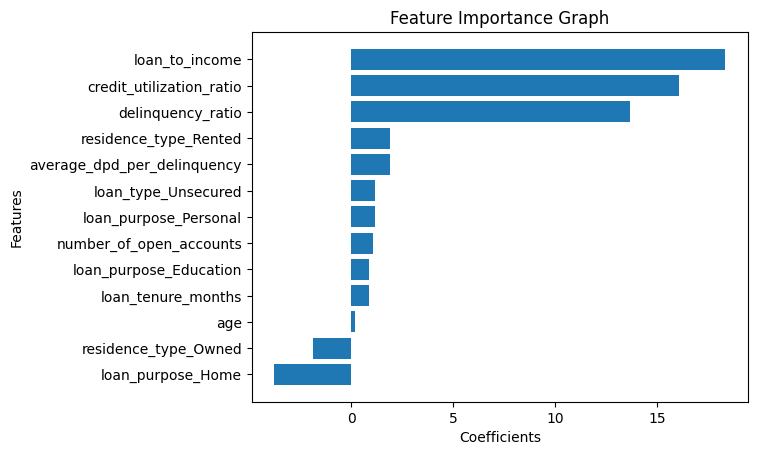

In [70]:
best_model = best_model_logistic
coefficients = best_model.coef_[0]
feature_importance_df = pd.DataFrame(coefficients,index = X_train_reduced.columns,columns = ['Coefficients'])
feature_importance_df.sort_values('Coefficients',ascending = True,inplace =  True)
plt.barh(feature_importance_df.index,feature_importance_df['Coefficients'])
plt.title("Feature Importance Graph")
plt.ylabel("Features")
plt.xlabel('Coefficients')
plt.show()

<h3 align = 'center' style='color:red'> Model Evaluation </h3>

In [71]:
probabilities = best_model_logistic.predict_proba(X_test_reduced)[:,1]

In [72]:
fpr,tpr,threshold = roc_curve(y_test,probabilities)

In [73]:
area = auc(fpr,tpr)

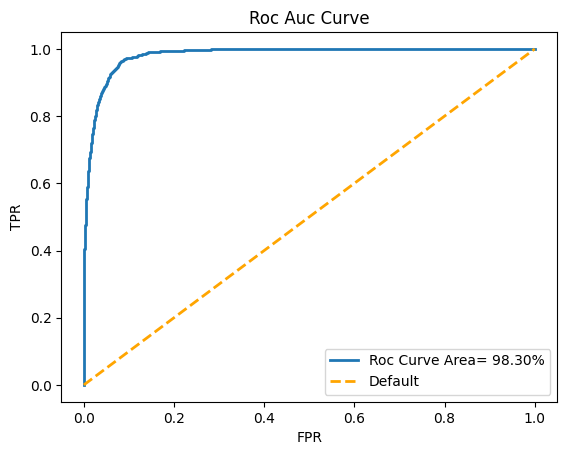

In [74]:
plt.plot(fpr,tpr,linewidth = 2,label = f"Roc Curve Area= {area*100:.2f}%")
plt.plot([0,1],[0,1],color = 'orange',linewidth = 2,label = 'Default',linestyle = 'dashed')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Roc Auc Curve")
plt.legend()
plt.show()

### Model Evaluatoin: Rank Order & KS Statistics

In [75]:
df_eval = pd.DataFrame({
    'Default Truth': y_test,
    'Default Probabilities':probabilities
})
df_eval.head()

,Default Truth,Default Probabilities
33553,0.0,0.000004
9427,0.0,0.774956
199,0.0,0.134614
12447,0.0,0.424504
39489,0.0,0.000856


In [76]:
df_eval['Decile'] = pd.qcut(df_eval['Default Probabilities'],10,labels = False,duplicates = 'drop')
df_eval.head()

,Default Truth,Default Probabilities,Decile
33553,0.0,0.000004,1
9427,0.0,0.774956,8
199,0.0,0.134614,7
12447,0.0,0.424504,8
39489,0.0,0.000856,5


In [77]:
df_grouped = df_eval.groupby('Decile').apply(lambda x: pd.Series({
    'Min Probability': x['Default Probabilities'].min(),
    'Max Probability': x['Default Probabilities'].max(),
    'Events': x['Default Truth'].sum(),
    'Non Events': x['Default Truth'].count() - x['Default Truth'].sum()
}))
df_grouped.reset_index(inplace = True)

C:\Users\Moksh Jain\AppData\Local\Temp\ipykernel_18792\1103330873.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_grouped = df_eval.groupby('Decile').apply(lambda x: pd.Series({


In [78]:
df_grouped

,Decile,Min Probability,Max Probability,Events,Non Events
0,0,8.107634e-10,6.819431e-07,0.0,1250.0
1,1,6.826822e-07,5.304654e-06,0.0,1250.0
2,2,5.330317e-06,2.908540e-05,0.0,1250.0
3,3,2.910075e-05,1.551546e-04,0.0,1249.0
4,4,1.552013e-04,7.728692e-04,0.0,1250.0
5,5,7.745615e-04,4.591310e-03,1.0,1249.0
6,6,4.596888e-03,3.003037e-02,2.0,1247.0
7,7,3.003097e-02,2.017213e-01,16.0,1234.0
8,8,2.018323e-01,8.222416e-01,171.0,1079.0
9,9,8.227666e-01,1.000000e+00,918.0,332.0


In [79]:
df_grouped['Event Rate'] = df_grouped['Events']*100/(df_grouped['Events']+df_grouped['Non Events'])
df_grouped['Non Event Rate'] = df_grouped['Non Events']*100/(df_grouped['Events']+df_grouped['Non Events'])

In [80]:
df_grouped = df_grouped.sort_values('Decile',ascending = False).reset_index(drop = True)
df_grouped

,Decile,Min Probability,Max Probability,Events,Non Events,Event Rate,Non Event Rate
0,9,8.227666e-01,1.000000e+00,918.0,332.0,73.440000,26.560000
1,8,2.018323e-01,8.222416e-01,171.0,1079.0,13.680000,86.320000
2,7,3.003097e-02,2.017213e-01,16.0,1234.0,1.280000,98.720000
3,6,4.596888e-03,3.003037e-02,2.0,1247.0,0.160128,99.839872
4,5,7.745615e-04,4.591310e-03,1.0,1249.0,0.080000,99.920000
5,4,1.552013e-04,7.728692e-04,0.0,1250.0,0.000000,100.000000
6,3,2.910075e-05,1.551546e-04,0.0,1249.0,0.000000,100.000000
7,2,5.330317e-06,2.908540e-05,0.0,1250.0,0.000000,100.000000
8,1,6.826822e-07,5.304654e-06,0.0,1250.0,0.000000,100.000000
9,0,8.107634e-10,6.819431e-07,0.0,1250.0,0.000000,100.000000


In [81]:
df_grouped['Cum Events'] = df_grouped['Events'].cumsum()
df_grouped['Non Cum Events'] = df_grouped['Non Events'].cumsum()
df_grouped

,Decile,Min Probability,Max Probability,Events,Non Events,Event Rate,Non Event Rate,Cum Events,Non Cum Events
0,9,8.227666e-01,1.000000e+00,918.0,332.0,73.440000,26.560000,918.0,332.0
1,8,2.018323e-01,8.222416e-01,171.0,1079.0,13.680000,86.320000,1089.0,1411.0
2,7,3.003097e-02,2.017213e-01,16.0,1234.0,1.280000,98.720000,1105.0,2645.0
3,6,4.596888e-03,3.003037e-02,2.0,1247.0,0.160128,99.839872,1107.0,3892.0
4,5,7.745615e-04,4.591310e-03,1.0,1249.0,0.080000,99.920000,1108.0,5141.0
5,4,1.552013e-04,7.728692e-04,0.0,1250.0,0.000000,100.000000,1108.0,6391.0
6,3,2.910075e-05,1.551546e-04,0.0,1249.0,0.000000,100.000000,1108.0,7640.0
7,2,5.330317e-06,2.908540e-05,0.0,1250.0,0.000000,100.000000,1108.0,8890.0
8,1,6.826822e-07,5.304654e-06,0.0,1250.0,0.000000,100.000000,1108.0,10140.0
9,0,8.107634e-10,6.819431e-07,0.0,1250.0,0.000000,100.000000,1108.0,11390.0


In [82]:
df_grouped['Cum Event Rate'] = df_grouped['Cum Events']*100/df_grouped['Events'].sum()
df_grouped['Non Cum Event Rate'] = df_grouped['Non Cum Events']*100/df_grouped['Non Events'].sum()
df_grouped

,Decile,Min Probability,Max Probability,Events,Non Events,Event Rate,Non Event Rate,Cum Events,Non Cum Events,Cum Event Rate,Non Cum Event Rate
0,9,8.227666e-01,1.000000e+00,918.0,332.0,73.440000,26.560000,918.0,332.0,82.851986,2.914838
1,8,2.018323e-01,8.222416e-01,171.0,1079.0,13.680000,86.320000,1089.0,1411.0,98.285199,12.388060
2,7,3.003097e-02,2.017213e-01,16.0,1234.0,1.280000,98.720000,1105.0,2645.0,99.729242,23.222125
3,6,4.596888e-03,3.003037e-02,2.0,1247.0,0.160128,99.839872,1107.0,3892.0,99.909747,34.170325
4,5,7.745615e-04,4.591310e-03,1.0,1249.0,0.080000,99.920000,1108.0,5141.0,100.000000,45.136084
5,4,1.552013e-04,7.728692e-04,0.0,1250.0,0.000000,100.000000,1108.0,6391.0,100.000000,56.110623
6,3,2.910075e-05,1.551546e-04,0.0,1249.0,0.000000,100.000000,1108.0,7640.0,100.000000,67.076383
7,2,5.330317e-06,2.908540e-05,0.0,1250.0,0.000000,100.000000,1108.0,8890.0,100.000000,78.050922
8,1,6.826822e-07,5.304654e-06,0.0,1250.0,0.000000,100.000000,1108.0,10140.0,100.000000,89.025461
9,0,8.107634e-10,6.819431e-07,0.0,1250.0,0.000000,100.000000,1108.0,11390.0,100.000000,100.000000


In [83]:
df_grouped['KS'] = df_grouped['Cum Event Rate']- df_grouped['Non Cum Event Rate']
df_grouped

,Decile,Min Probability,Max Probability,Events,Non Events,Event Rate,Non Event Rate,Cum Events,Non Cum Events,Cum Event Rate,Non Cum Event Rate,KS
0,9,8.227666e-01,1.000000e+00,918.0,332.0,73.440000,26.560000,918.0,332.0,82.851986,2.914838,79.937148
1,8,2.018323e-01,8.222416e-01,171.0,1079.0,13.680000,86.320000,1089.0,1411.0,98.285199,12.388060,85.897139
2,7,3.003097e-02,2.017213e-01,16.0,1234.0,1.280000,98.720000,1105.0,2645.0,99.729242,23.222125,76.507117
3,6,4.596888e-03,3.003037e-02,2.0,1247.0,0.160128,99.839872,1107.0,3892.0,99.909747,34.170325,65.739422
4,5,7.745615e-04,4.591310e-03,1.0,1249.0,0.080000,99.920000,1108.0,5141.0,100.000000,45.136084,54.863916
5,4,1.552013e-04,7.728692e-04,0.0,1250.0,0.000000,100.000000,1108.0,6391.0,100.000000,56.110623,43.889377
6,3,2.910075e-05,1.551546e-04,0.0,1249.0,0.000000,100.000000,1108.0,7640.0,100.000000,67.076383,32.923617
7,2,5.330317e-06,2.908540e-05,0.0,1250.0,0.000000,100.000000,1108.0,8890.0,100.000000,78.050922,21.949078
8,1,6.826822e-07,5.304654e-06,0.0,1250.0,0.000000,100.000000,1108.0,10140.0,100.000000,89.025461,10.974539
9,0,8.107634e-10,6.819431e-07,0.0,1250.0,0.000000,100.000000,1108.0,11390.0,100.000000,100.000000,0.000000


Insights:  
- We are getting 85 KS in 2nd Decile only.
- It's more than 40.
- It means our model is able to capture Default and Non default in 2nd(8) decile only.
- Model is performing extremely good.

### Gini Coefficient

In [84]:
gini = 2*area-1
print("AUC: ",area)
print("Gini Coefficient: ",gini)

AUC:  0.9829530147098442
Gini Coefficient:  0.9659060294196884


<h3 align= 'center' style="color:red"> Save the Model </h3>

In [ ]:
X_test_reduced.head(2)

In [ ]:
X_test_reduced.columns

In [ ]:
col_to_scale

In [ ]:
model_data ={
    'model':best_model,
    'col_to_scale':col_to_scale,
    'scaler': scaler,
    'features':X_test_reduced.columns
}
dump(model_data,'artifacts/model_data.joblib')